<a href="https://colab.research.google.com/github/hida0/ESAA/blob/2022-1-Study/Study_Week1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [제주 버스 운행시간 예측 모델링 대회]
next_arrive_time : 다음 정류장에 도착할 때 까지 걸린 시간(단위:초)으로 답안 제출을 위해서 예측해야 되는 값

### 1. 라이브러리 및 데이터 로드

In [2]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from xgboost import XGBRegressor 
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/ESAA/2022-1 Study/Week1/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/ESAA/2022-1 Study/Week1/test.csv")
train_data.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


### 2. 데이터 전처리
#### 2-1. **이상치 제거**
- 학습에 방해가 될 수 있는 이상치를 제거한다.
- 가장 최고의 distance의 next_arrive_time이 600대였으므로, 700 이상의 너무 큰 시간을 소비하는 구간은 측정 오류로 판단하여 제거한다.
> $&lt;$ 는 작다를 나타내는 **<** 를, $&gt;$ 는 크다를 나타내는 **>** 의미한다.

In [4]:
train_data = train_data[train_data['next_arrive_time'] <= 700]

### 2. 데이터 전처리
#### 2-2. **정류장명 인코딩** 작업
- 모델로 사용할 **XGBoost 알고리즘은 숫자 데이터만 취급**하므로, 정류장 이름 칼럼인 now_station과 next_station을 **LabelEncoder**를 이용하여 치환한다.

In [5]:
station_encoder = LabelEncoder()
_station = list(train_data['now_station'].values) + list(train_data['next_station'].values)
station_set = set(_station)
len(station_set)

351

In [6]:
station_encoder.fit(list(station_set))

# 학습 데이터와 시험 데이터의 정류장 칼럼을 치환
train_data['now_station'] = station_encoder.transform(train_data['now_station'])
train_data['next_station'] = station_encoder.transform(train_data['next_station'])
test_data['now_station'] = station_encoder.transform(test_data['now_station'])
test_data['next_station'] = station_encoder.transform(test_data['next_station'])
train_data.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64


### 3. 탐색적 자료 분석(EDA)
- 도착시간과 예측시간의 분포를 확인한다.
- 도착시간의 시간대를 살펴본 결과 **01시~04시의 데이터가 존재하지 않는다**는 것을 확인했다. **시간대** feature를 생성할 때, **'새벽'은 추가하지 않기**로 결정한다.
- 또한 도착시간의 값들이 **대부분 0~200 사이의 값에서 분포하고 있음**을 확인하여, 700 이상의 값들을 포함하지 않은 것이 유용하다고 판단하였다.

In [ ]:
#한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

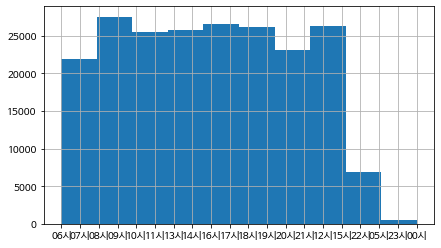

In [ ]:
times_ = train_data['now_arrive_time']
plt.figure(figsize=(7,5))
times_.hist()
plt.show()

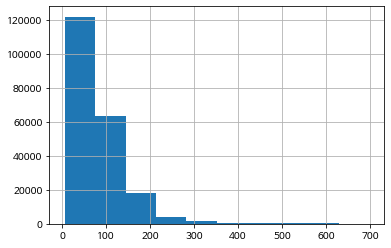

In [ ]:
target_ = train_data['next_arrive_time']
target_.hist()
plt.show()

### 4. 변수 선택 및 모델 구축
#### 4-1. 날짜 -> 요일 -> **평일/주말 변환**
- date 값을 이용할 수 있도록 의미있는 값으로 변환한다.
- 먼저 **to_datetime**을 이용하여 **각 날짜를 요일로** 변환하고, 이를 **dt**의 특성을 이용하여 **평일과 주말** 두 가지로 분류한다.
> - df['Birth'].dt.quarter       # 분기(숫자)
  - df['Birth'].dt.weekday_name  # 요일이름(문자) (=day_name())
 - df['Birth'].dt.weekday       # 요일숫자(0-월, 1-화) (=dayofweek)
- 요일을 평일과 주말로 변환후 **원핫인코딩**한다.

In [7]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['weekday'] = train_data['date'].dt.weekday # Monday는 0부터 Sunday는 6
train_data['weekday'] = train_data['weekday'].apply(lambda x: 0 if x < 5 else 1) # 0부터 4는 월~금요일이므로 평일인 0으로, 5와 6 은 주말이므로 1로 변환
train_data.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42,0
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64,0


In [8]:
# 평일과 주말에 대해 원핫인코딩
train_data = pd.get_dummies(train_data, columns=['weekday'])
train_data = train_data.drop('date', axis=1)
train_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1
0,0,405136001,7997025,360-1,33.456267,126.551750,239,06시,266.0,227,33.457724,126.554014,24,1,0
1,1,405136001,7997025,360-1,33.457724,126.554014,227,06시,333.0,228,33.458783,126.557353,36,1,0
2,2,405136001,7997025,360-1,33.458783,126.557353,228,06시,415.0,235,33.459893,126.561624,40,1,0
3,3,405136001,7997025,360-1,33.479705,126.543811,41,06시,578.0,249,33.484860,126.542928,42,1,0
4,4,405136001,7997025,360-1,33.485662,126.494923,63,07시,374.0,221,33.485822,126.490897,64,1,0


In [9]:
# 마찬가지로 테스트 데이터도 변환
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['weekday'] = test_data['date'].dt.weekday # Monday는 0부터 Sunday는 6
test_data['weekday'] = test_data['weekday'].apply(lambda x: 0 if x < 5 else 1) # 0부터 4는 월~금요일이므로 평일인 0으로, 5와 6 은 주말이므로 1로 변환
test_data = pd.get_dummies(test_data, columns=['weekday'])
test_data = test_data.drop('date', axis=1)
test_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,07시,333.0,228,33.458783,126.557353,1,0
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,07시,415.0,235,33.459893,126.561624,1,0
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,08시,417.0,59,33.478850,126.488350,1,0
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,08시,334.0,183,33.480700,126.489933,1,0
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,08시,550.0,285,33.482077,126.485355,1,0


### 4. 변수 선택 및 모델 구축
#### 4-2. 정류장 출발 시간 **아침/오후/저녁** 3분류 변환
- 시간대를 기존처럼 24개로 둔다면 모델의 복잡도가 증가할 수 있으므로, 과적합을 막기 위해 시간대를 **아침/오후/저녁** 3가지로 분류하여 변환한다.
- 시간대를 아침/오후/저녁으로 변환후 **원핫인코딩**한다.


In [10]:
train_data['time_group'] = 'group' # time_group 칼럼을 미리 생성

# now_arrive_time이 05시~11시인 time_group 칼럼에 morning을 입력
train_data.loc[(train_data['now_arrive_time'] >= '05시') & (train_data['now_arrive_time'] < '12시'), ['time_group']] = 'morning'

# now_arrive_time이 12시~17시인 time_group 칼럼에 afternoon을 입력
train_data.loc[(train_data['now_arrive_time'] >= '12시') & (train_data['now_arrive_time'] < '18시'), ['time_group']] = 'afternoon'

# now_arrive_time이 18시~00시인 time_group 칼럼에 evening을 입력
train_data.loc[(train_data['now_arrive_time'] >= '18시') | (train_data['now_arrive_time'] == '00시'), ['time_group']] = 'evening'

In [11]:
# 아침/오후/저녁에 대해 원핫인코딩
train_data = pd.get_dummies(train_data, columns=['time_group'])
train_data = train_data.drop('now_arrive_time', axis=1)
train_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,360-1,33.456267,126.551750,239,266.0,227,33.457724,126.554014,24,1,0,0,0,1
1,1,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,36,1,0,0,0,1
2,2,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,40,1,0,0,0,1
3,3,405136001,7997025,360-1,33.479705,126.543811,41,578.0,249,33.484860,126.542928,42,1,0,0,0,1
4,4,405136001,7997025,360-1,33.485662,126.494923,63,374.0,221,33.485822,126.490897,64,1,0,0,0,1


In [12]:
# 마찬가지로 테스트 데이터도 변환
test_data['time_group'] = 'group' # time_group 칼럼을 미리 생성

# now_arrive_time이 05시~11시인 time_group 칼럼에 morning을 입력
test_data.loc[(test_data['now_arrive_time'] >= '05시') & (test_data['now_arrive_time'] < '12시'), ['time_group']] = 'morning'

# now_arrive_time이 12시~17시인 time_group 칼럼에 afternoon을 입력
test_data.loc[(test_data['now_arrive_time'] >= '12시') & (test_data['now_arrive_time'] < '18시'), ['time_group']] = 'afternoon'

# now_arrive_time이 18시~00시인 time_group 칼럼에 evening을 입력
test_data.loc[(test_data['now_arrive_time'] >= '18시') | (test_data['now_arrive_time'] == '00시'), ['time_group']] = 'evening'

test_data = pd.get_dummies(test_data, columns=['time_group'])
test_data = test_data.drop('now_arrive_time', axis=1)
test_data.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,360-1,33.457724,126.554014,227,333.0,228,33.458783,126.557353,1,0,0,0,1
1,210458,405136001,7997025,360-1,33.458783,126.557353,228,415.0,235,33.459893,126.561624,1,0,0,0,1
2,210459,405136001,7997025,360-1,33.478867,126.483833,323,417.0,59,33.478850,126.488350,1,0,0,0,1
3,210460,405136001,7997025,360-1,33.478850,126.488350,59,334.0,183,33.480700,126.489933,1,0,0,0,1
4,210461,405136001,7997025,360-1,33.480700,126.489933,183,550.0,285,33.482077,126.485355,1,0,0,0,1


### 4. 변수 선택 및 모델 구축
#### 4-3. 학습에 필요 없는 칼럼 제거
- id 칼럼은 학습에서 의미가 없으므로 제거한다. 그러나 테스트 데이터에서는 제출 파일 생성시 필요하므로 남겨둔다.
- route_nm(버스 노선 실제 번호) 칼럼은 route_id(버스 노선 ID)와 같은 역할의 데이터이므로 중복된다고 판단하여 제거한다.
- latitude(위도)와 longitude(경도)는 큰 의미가 없고, 모델의 복잡도만 높인다고 판단하여 제거한다.

In [13]:
train_data = train_data.drop(['id', 'route_nm', 'now_latitude', 'now_longitude', 'next_latitude', 'next_longitude'], axis=1)
train_data.head(3)

,route_id,vh_id,now_station,distance,next_station,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,405136001,7997025,239,266.0,227,24,1,0,0,0,1
1,405136001,7997025,227,333.0,228,36,1,0,0,0,1
2,405136001,7997025,228,415.0,235,40,1,0,0,0,1


In [14]:
test_data = test_data.drop(['route_nm', 'now_latitude', 'now_longitude', 'next_latitude', 'next_longitude'], axis=1)
test_data.head(3)

,id,route_id,vh_id,now_station,distance,next_station,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,227,333.0,228,1,0,0,0,1
1,210458,405136001,7997025,228,415.0,235,1,0,0,0,1
2,210459,405136001,7997025,323,417.0,59,1,0,0,0,1


### 4. 변수 선택 및 모델 구축
#### 4-4. 설명변수(X)와 예측변수(Y) 데이터 구성
- 학습 데이터에서 예측 목표치인 next_arrive_time을 제거한 데이터를 Xtrain으로, next_arrive_time 칼럼을 Ytrain로 저장한다.

In [15]:
input_var = list(train_data.columns)
input_var.remove('next_arrive_time')
# 학습 데이터
Xtrain = train_data[input_var]
# Xtrain = train_data.drop('next_arrive_time', axis=1)
Ytrain = train_data['next_arrive_time']

# 테스트 데이터
Xtest = test_data[input_var]

### 4. 변수 선택 및 모델 구축
#### 4-5. 모델 구축 및 학습 준비
- 빠른 학습과 높은 정밀도를 보장하는 **XGB Regressor(eXtreme Gradient Boosting)** 모델을 사용한다.
- **K-Fold**를 이용하여 **K-Validation** 교차 검증을 수행한다.
- 모델의 random_state는 110으로, Kfold의 random_state는 777로 고정한다.

In [16]:
model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
kfold = KFold(n_splits=8, shuffle=True, random_state=777)
n_iter = 0
cv_score = []

### 5. 모델 학습 및 검증
#### 5-1. 모델 학습 및 검증
- for 문을 통해 **kfold.split** 를 이용하여 분할된 인덱스값을 구하고, **iloc 연산자** 로 학습용 데이터와 테스트용 데이터로 분할하여 모델의 학습과 예측을 수행한다.
- 정확도 계산을 위해 RMSE 값을 계산하는 함수를 정의한다.
- 이 함수를 이용하여 교차 검증별 RMSE와 평균 검증 RMSE를 계산한다.

In [17]:
# np.power(array, number) : array 각각의 값^number 형태
def rmse(target, pred):
    return np.sqrt(np.sum(np.power(target-pred, 2)) / np.size(pred))

In [19]:
for train_index, test_index in kfold.split(Xtrain, Ytrain):
    # K-Fold가 적용된 train, test 데이터로 분할
    X_train, X_test = Xtrain.iloc[train_index, :], Xtrain.iloc[test_index, :]
    Y_train, Y_test = Ytrain.iloc[train_index], Ytrain.iloc[test_index]

    # 모델 학습과 예측 수행
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    
    # 정확도 RMSE 계산
    n_iter += 1
    score = rmse(Y_test, pred)
    cv_score.append(score)

print("교차 검증별 RMSE: ", np.round(cv_score, 4))
print("평균 검증 RMSE: ", np.mean(cv_score))

교차 검증별 RMSE:  [31.683  32.5576 32.2099 31.8825 32.2631 32.439  31.852  32.0893]
평균 검증 RMSE:  32.12206561750763


### 5. 모델 학습 및 검증
#### 5-2. 데이터 특성 중요도 분석
- 데이터의 **각 피처의 중요도를 분석**한다.
- 학습한 모델에 **feature_importances** 메서드를 이용하여 트리 분할에 관한 피처들의 중요도를 확인할 수 있다.

In [20]:
n_feature = X_train.shape[1] # 주어진 변수들의 개수
index = np.arange(n_feature)

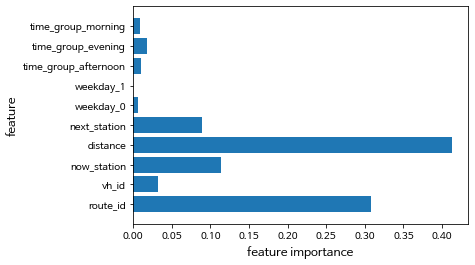

In [21]:
plt.barh(index, model.feature_importances_, align='center')
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=12)
plt.ylabel('feature', size=12)
plt.show()

### 5. 모델 학습 및 검증
#### 5-2. 데이터 피처 중요도 분석
- 피처들의 중요도를 그래프로 그려본 결과, distance가 시간 예측에 가장 중요한 판단 지표였다.
- 버스 노선인 route_id도 시간 예측에 상당한 지분을 차지하였으며, 출발/도착 정류장 종류인 now/next station도 유의미한 가중치를 가졌다.

### 6. 결과
- 테스트 데이터에 대한 예측을 진행한다.

In [22]:
submission = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1 Study/Week1/submission_제출양식.csv')
submission.head(3)

,id,next_arrive_time
0,210457,0
1,210458,0
2,210459,0


In [24]:
result = model.predict(Xtest)
submission['next_arrive_time'] = result
submission.head()

,id,next_arrive_time
0,210457,36.711113
1,210458,51.268673
2,210459,129.317230
3,210460,57.016850
4,210461,148.215240
